ここ最近pymcを使ったベイズ推論のことをずっと考えています(2018年6月執筆当時)。pymc3を扱った本(<http://amzn.asia/1TWcfTI>)が先週発売されて買ってしまったのですが、まだ前のpymc本(<http://amzn.asia/8CPISDp>)を読み切っていなかったので急いで読み切りました。読み切った記念に一個面白そうなものがあったのでまとめました。

## 概要
2群の平均値に差があるかどうか比べたいというよくある問いに対しては一般にt検定が使われます。当分散性が言えるとき（2郡の分散が同じである確信が持てるとき）はStudent's t-testを使います。

当分散性が言えないときは（自信がないときも保守的に）Welch's t-testを使います。余談ですが、どちらのt-testも平均値が正規分布に従うことを仮定しているので、その仮定が怪しいときはノンパラメトリックな検定を選びます。この辺りは誰かがコード付きでまとめてくれると信じてます。

このt検定ですが、ベイズ風のアレンジの論文が存在するようです。
**BEST**(Bayesian estimation supersedes the t-test)
というかっこいい名前です。
> Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.


2群それぞれを独立にt分布に従うと仮定し、それぞれ3つのパラメーター（平均、分散、外れ値）
を推論します。つまり、6つのパラメーターを推論します。ベイズ推論に落とし込むことで、2群それぞれの平均、分散、外れ値の解釈が容易になります。

## Bayesian estimation supersedes the t-test (BEST)
以下ではpymc3を用いてBESTを行います。まず、pymc3をpipでインストールしておきましょう：`pip install pymc3`

(参考)
- https://docs.pymc.io/notebooks/BEST.html
- 「Pythonで体験するベイズ推論」　Cameron Davidson-Pilon / 玉木 徹

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\yamta\miniconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026EBD103348>,
      dtype=object)

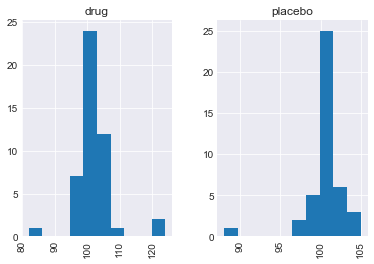

In [2]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group')

In [3]:
y.head()

,value,group
0,101,drug
1,100,drug
2,102,drug
3,104,drug
4,102,drug


In [4]:
mu_m = y.value.mean()
mu_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu_m, sd=mu_s)
    group2_mean = pm.Normal('group2_mean', mu_m, sd=mu_s)

In [5]:
sigma_low = 1
sigma_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high)

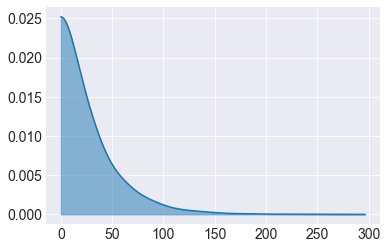

In [6]:
with model:
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), 
           fill_kwargs={'alpha':0.5})

In [7]:
with model:
    lam_1 = group1_std**-2
    lam_2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=nu, mu=group1_mean, lam=lam_1, observed=y1)
    group2 = pm.StudentT('placebo', nu=nu, mu=group2_mean, lam=lam_2, observed=y2)

In [8]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [9]:
model

### パラメータの解釈

t分布は３つのパラメータ$\mu$, $\sigma$, $\nu$　がある。

- $\mu$ : 平均値。正規分布からサンプルする。
- $\sigma$ : 分散。一様分布からサンプルする。
- $\nu$ : 外れ値の観測しやすさ。指数分布を+1shiftした分布からサンプルする。

このt分布をgroup1, group2に対して推論する。

In [10]:
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 5000/5000 [03:06<00:00, 26.74draws/s]


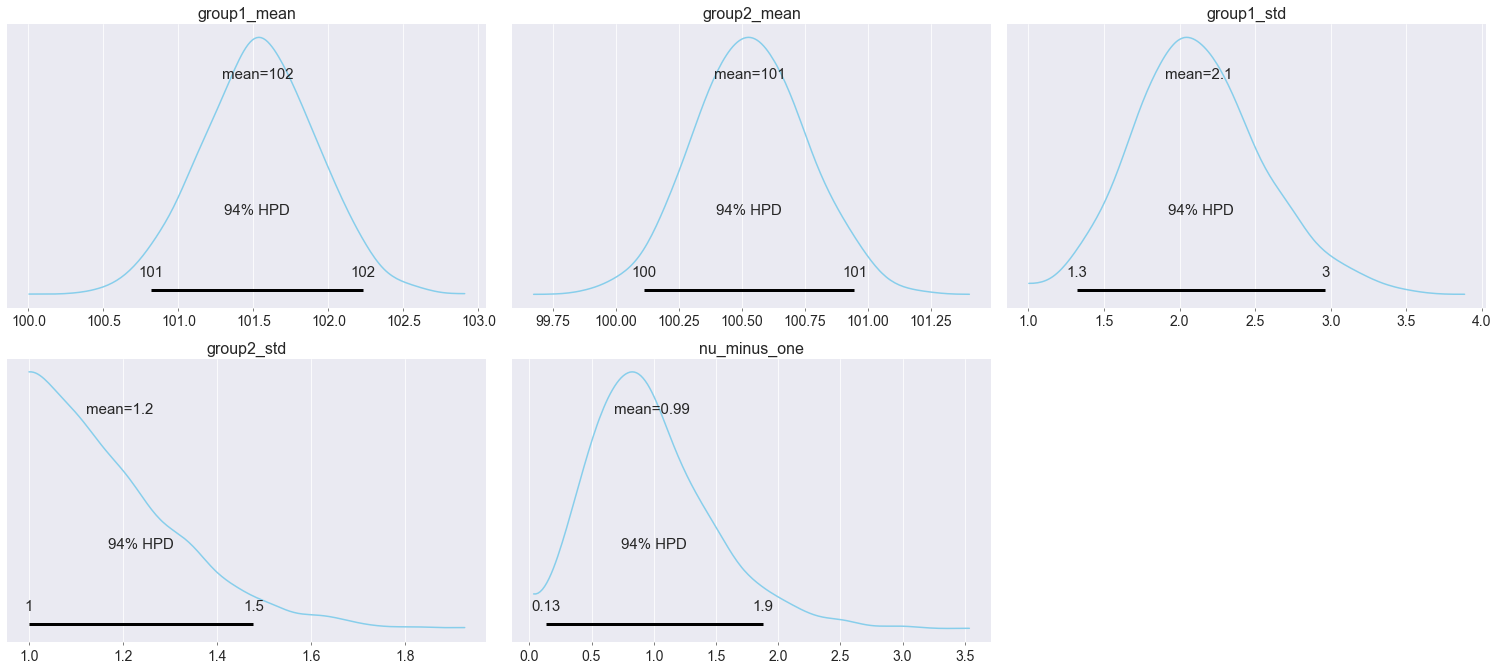

In [11]:
pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'nu_minus_one'],
                  color='#87ceeb');

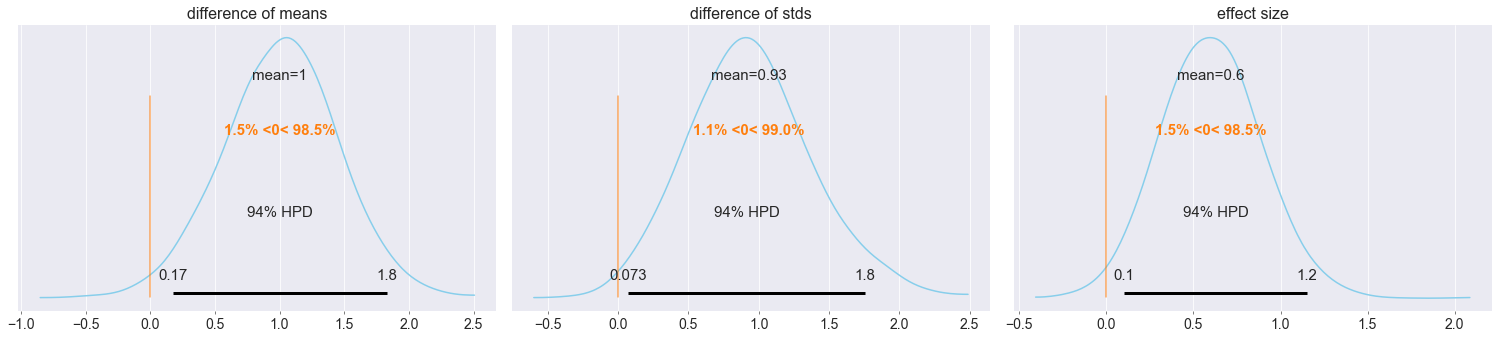

In [12]:
pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

difference of meansは95%以上が0を超えているので、優位にgroup1のほうが高い事がわかる。

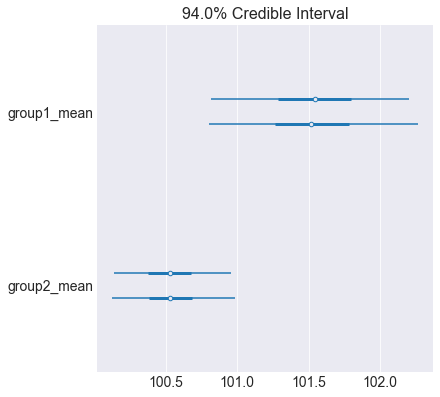

In [13]:
pm.forestplot(trace, var_names=['group1_mean',
                               'group2_mean']);

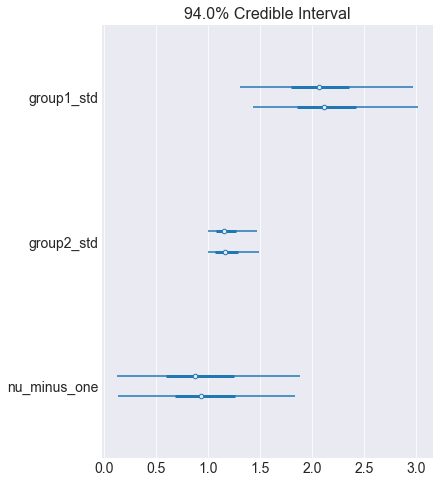

In [14]:
pm.forestplot(trace, var_names=['group1_std',
                               'group2_std',
                               'nu_minus_one']);

In [15]:
pm.summary(trace, var_names=['difference of means', 'difference of stds', 'effect size'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
difference of means,1.000,0.445,0.175,1.832,0.008,0.006,3052.0,2952.0,3082.0,2648.0,1.0
difference of stds,0.931,0.443,0.073,1.754,0.009,0.007,2235.0,2235.0,2148.0,1786.0,1.0
effect size,0.596,0.284,0.102,1.154,0.005,0.004,2895.0,2895.0,2889.0,2658.0,1.0


In [16]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
group1_mean,101.531,0.384,100.815,102.233,0.007,0.005,3037.0,3037.0,3059.0,2447.0,1.0
group2_mean,100.531,0.225,100.109,100.947,0.004,0.003,2996.0,2993.0,3024.0,2205.0,1.0
group1_std,2.124,0.434,1.321,2.963,0.009,0.007,2097.0,2097.0,1999.0,1498.0,1.0
group2_std,1.193,0.157,1.000,1.477,0.003,0.002,3323.0,3323.0,2443.0,1670.0,1.0
nu_minus_one,0.986,0.496,0.134,1.875,0.010,0.007,2690.0,2690.0,2461.0,2290.0,1.0
difference of means,1.000,0.445,0.175,1.832,0.008,0.006,3052.0,2952.0,3082.0,2648.0,1.0
difference of stds,0.931,0.443,0.073,1.754,0.009,0.007,2235.0,2235.0,2148.0,1786.0,1.0
effect size,0.596,0.284,0.102,1.154,0.005,0.004,2895.0,2895.0,2889.0,2658.0,1.0


### 事後分布の生成

サンプルしたパラメーターを用いてt分布の事後分布を作成する。`pm.sample_posterior_predictive`を使う。

https://docs.pymc.io/notebooks/posterior_predictive.html

In [17]:
ppc = pm.sample_posterior_predictive(trace, samples=50000, model=model)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:02<00:00, 800.32it/s]


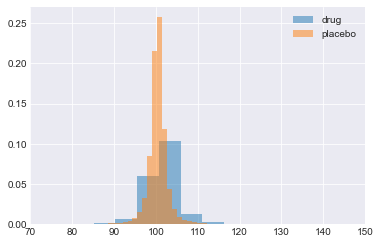

In [18]:
# import seaborn as sns
# sns.kdeplot(ppc['drug'].flatten(), bw = 10)
# sns.kdeplot(ppc['placebo'].flatten(), bw = 10)
# plt.hist(ppc['drug'], bins=1000, density=True, label='drug', alpha=.5)
# plt.hist(ppc['placebo'], bins=1000, density=True, label='placebo', alpha=.5)
plt.hist(ppc['drug'][:, 0], bins=1000, density=True, label='drug', alpha=.5)
plt.hist(ppc['placebo'][:, 0], bins=1000, density=True, label='placebo', alpha=.5)
plt.xlim(70,150)
plt.legend()
plt.show()

### 普通のT検定
分散が違うことがわかっているのでWelch's t-testをやってみます。

In [19]:
y1

array([101, 100, 102, 104, 102,  97, 105, 105,  98, 101, 100, 123, 105,
       103, 100,  95, 102, 106, 109, 102,  82, 102, 100, 102, 102, 101,
       102, 102, 103, 103,  97,  97, 103, 101,  97, 104,  96, 103, 124,
       101, 101, 100, 101, 101, 104, 100, 101])

In [20]:
from scipy import stats

res = stats.ttest_ind(y1, y2, equal_var = False)
res

Ttest_indResult(statistic=1.622190457290228, pvalue=0.10975381983712831)

優位性示せず。


In [21]:
import seaborn as sns

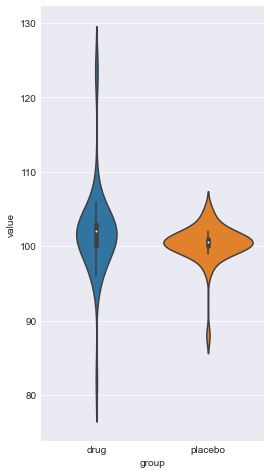

In [22]:
plt.figure(figsize=(4,8))
sns.violinplot(x='group', y='value', data=y)#, scale="count", inner="stick")